In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import pathlib
import pandas as pd
import matplotlib.pyplot as plt

Number Of Classes    :  12
Number Of Images(Training,Testing):  1583 300


Distribution Per Class


<AxesSubplot:>

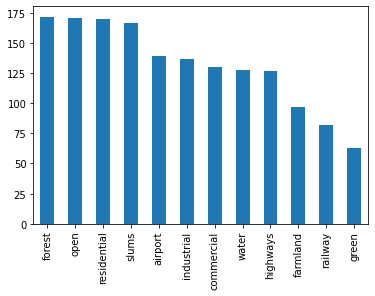

In [2]:
#train_ds = pd.read_csv("../input/landuse-scene-classification/train.csv")
#train_ds['Filename']=train_ds['Filename'].apply(lambda x:"train/"+x)
#val_ds = pd.read_csv("../input/landuse-scene-classification/validation.csv")
#val_ds['Filename']=val_ds['Filename'].apply(lambda x:"validation/"+x)
#ds = pd.concat([train_ds,val_ds]).sample(frac=1).reset_index(drop=True)

data_dir = pathlib.Path("../input/landusedataset/images")
paths = list(data_dir.glob('*/*.jpg'))
def load_paths(path):
    path = path.absolute().as_posix()
    path = path.split('/')
    return path[-2]+"/"+path[-1],path[-2]
ds = pd.DataFrame(map(load_paths,paths),columns =['image','label']).sample(frac=1).reset_index(drop=True)
ds['Class'] = pd.factorize(ds['label'])[0]
ds = ds.sample(frac=1).reset_index(drop=True)

test_ds = ds.iloc[:300,:]
ds = ds.iloc[300:,:]

n = int(len(ds))
classes = ds.label.nunique()
print("Number Of Classes    : ",classes)
print("Number Of Images(Training,Testing): ",n,int(len(test_ds)))
print("\n\nDistribution Per Class")
ds['label'].value_counts().plot.bar()

In [3]:
ds.head()

,image,label,Class
300,farmland/1233012122022132133.jpg,farmland,4
301,residential/1233003111221010133.jpg,residential,1
302,green/1233003113001223033.jpg,green,11
303,railway/1233003113001231120.jpg,railway,5
304,residential/1233003111303030322.jpg,residential,1


In [4]:
def load_img(path,label):
    img = tf.io.decode_jpeg(tf.io.read_file("../input/landusedataset/images/"+path),channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, [224,224])
    img = keras.applications.vgg16.preprocess_input(img)
    return img,label

In [5]:
dataset = tf.data.Dataset.from_tensor_slices((ds.image.values,ds.Class.values))

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = dataset.take(int(0.8*len(ds)))
val_ds = dataset.take(int(0.2*len(ds)))

train = train_ds.map(load_img,num_parallel_calls=AUTOTUNE).batch(32).prefetch(buffer_size=AUTOTUNE)
val   = val_ds.map(load_img,num_parallel_calls=AUTOTUNE).batch(32).prefetch(buffer_size=AUTOTUNE)

In [7]:
base_model = keras.applications.VGG16(weights="imagenet",include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(classes, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

58892288/58889256 [==============================] - 0s 0us/step


In [8]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
history = model.fit(train, epochs=15, validation_data=val,verbose=1)

Epoch 1/15
40/40 [==============================] - 20s 262ms/step - loss: 4.1134 - accuracy: 0.2291 - val_loss: 1.1347 - val_accuracy: 0.6456
Epoch 2/15
40/40 [==============================] - 5s 123ms/step - loss: 0.9731 - accuracy: 0.7183 - val_loss: 0.6129 - val_accuracy: 0.8038
Epoch 3/15
40/40 [==============================] - 5s 116ms/step - loss: 0.5607 - accuracy: 0.8273 - val_loss: 0.4329 - val_accuracy: 0.8639
Epoch 4/15
40/40 [==============================] - 4s 108ms/step - loss: 0.3990 - accuracy: 0.8759 - val_loss: 0.3387 - val_accuracy: 0.8956
Epoch 5/15
40/40 [==============================] - 4s 105ms/step - loss: 0.3061 - accuracy: 0.9037 - val_loss: 0.2768 - val_accuracy: 0.9177
Epoch 6/15
40/40 [==============================] - 5s 111ms/step - loss: 0.2444 - accuracy: 0.9332 - val_loss: 0.2336 - val_accuracy: 0.9241
Epoch 7/15
40/40 [==============================] - 4s 105ms/step - loss: 0.2010 - accuracy: 0.9428 - val_loss: 0.2004 - val_accuracy: 0.9430
Epoch

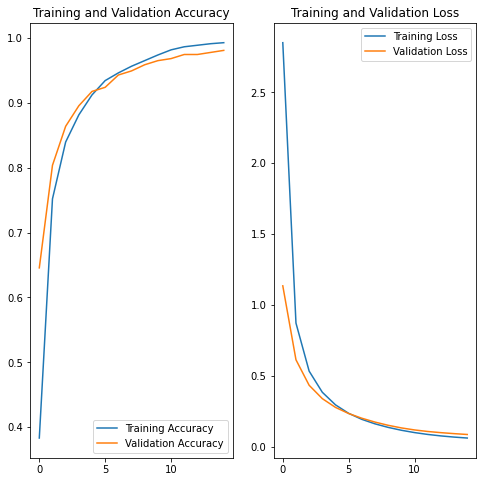

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['val_loss']))
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [10]:
test_x = tf.data.Dataset.from_tensor_slices((test_ds.image.values,test_ds.Class.values))
test_x = test_x.map(load_img).batch(32)

score = model.evaluate(test_x, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.43457406759262085
Test accuracy: 0.8833333253860474


In [11]:
model.save("land_classifier.h5")